# Comparativa de Modelos Transformer para Detección de Comentarios Tóxicos

Este notebook implementa y compara diferentes modelos Transformer (BERT, RoBERTa, DistilBERT y XLNet) para la detección de comentarios tóxicos, utilizando como referencia la implementación de BERT en el archivo `bert_fit.ipynb`.

## 1. Importación de Bibliotecas

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import os
import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import emoji
import warnings


In [4]:
warnings.filterwarnings('ignore')

# Definir una ruta específica para los datos de NLTK
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)

# Descargar los recursos especificando la ruta
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)

# Añadir la ruta al path de NLTK
nltk.data.path.append(nltk_data_path)

# Configurar estilo de visualización
plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to C:\Users\Yho\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Yho\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yho\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Yho\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Verificar si CUDA está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

Usando dispositivo: cuda
2.5.1+cu121
True
NVIDIA GeForce RTX 4070


## 2. Carga y Preprocesamiento de Datos

In [6]:
# Cargar el dataset
data_path = '../Data/fusion30.csv'
df = pd.read_csv(data_path, sep=';')
print(f'Forma del dataset: {df.shape}')
df.head()

Forma del dataset: (29970, 12)


,Record,General_judgement,Aligned_with_label,Violence (Low),Violence_judgement,Hate (Low),Hate_judgement,Sexual (Low),Sexual_judgement,Self-harm (Low),Self-harm_judgement,result
0,"""Cry me a river, why don't you.\r\nDrinking, d...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1
1,"""That's right. They are not normal. And I am s...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1
2,"""Disgusting.""",Accepted,N,SAFE,Accept,SAFE,Accept,SAFE,Accept,SAFE,Accept,0
3,"""gtfo""",Accepted,N,SAFE,Accept,SAFE,Accept,SAFE,Accept,SAFE,Accept,0
4,"""All you ever talk about is trolling, you and ...",Rejected,Y,SAFE,Accept,LOW,Reject,SAFE,Accept,SAFE,Accept,1


In [7]:
# Preparar los datos para el modelo
# Extraer texto y etiquetas
texts = df['Record'].str.strip('"').values
labels = df['result'].values

# Verificar la distribución de clases
print('Distribución de clases:')
print(pd.Series(labels).value_counts())


Distribución de clases:
1    16468
0    13502
Name: count, dtype: int64


### Funciones de Preprocesamiento

In [8]:
def preprocess_text(text):
    '''
    Función para preprocesar el texto
    '''
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Convertir emojis a texto
    text = emoji.demojize(text)
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lematizar
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Unir tokens
    text = ' '.join(tokens)
    
    return text

In [9]:
# Aplicar preprocesamiento a los textos
preprocessed_texts = [preprocess_text(text) for text in tqdm(texts, desc='Preprocesando textos')]

Preprocesando textos: 100%|██████████| 29970/29970 [00:12<00:00, 2390.34it/s]


In [10]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
# Primero, dividir en entrenamiento y temporal (validación + prueba)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    preprocessed_texts, labels, test_size=0.3, random_state=42, stratify=labels
)

# Luego, dividir el conjunto temporal en validación y prueba
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f'Tamaño del conjunto de entrenamiento: {len(train_texts)}')
print(f'Tamaño del conjunto de validación: {len(val_texts)}')
print(f'Tamaño del conjunto de prueba: {len(test_texts)}')

Tamaño del conjunto de entrenamiento: 20979
Tamaño del conjunto de validación: 4495
Tamaño del conjunto de prueba: 4496


## 3. Implementación de la Clase Dataset

In [11]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenizar el texto
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Eliminar la dimensión extra
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        # Para BERT y DistilBERT necesitamos token_type_ids
        if 'token_type_ids' in encoding:
            token_type_ids = encoding['token_type_ids'].squeeze()
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids,
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:  # Para RoBERTa y XLNet no usamos token_type_ids
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            }

## 4. Funciones de Entrenamiento y Evaluación

In [12]:
def train_epoch(model, dataloader, optimizer, scheduler, device, model_type):
    '''
    Función para entrenar una época
    '''
    # Poner el modelo en modo de entrenamiento
    model.train()
    
    # Inicializar variables para seguimiento
    total_loss = 0
    predictions = []
    actual_labels = []
    
    # Iterar sobre los batches
    for batch in tqdm(dataloader, desc='Entrenando'):
        # Extraer datos del batch
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Reiniciar gradientes
        optimizer.zero_grad()
        
        # Construir kwargs dinámicamente
        model_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
        # Solo agregar token_type_ids si el modelo los necesita y están disponibles
        if model_type == 'bert' and 'token_type_ids' in batch:
            model_inputs["token_type_ids"] = batch['token_type_ids'].to(device)

        outputs = model(**model_inputs)   
   
        
        # Obtener pérdida y logits
        loss = outputs.loss
        logits = outputs.logits
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Acumular pérdida
        total_loss += loss.item()
        
        # Obtener predicciones
        _, preds = torch.max(logits, dim=1)
        
        # Guardar predicciones y etiquetas reales
        predictions.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())
    
    # Calcular métricas
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions)
    recall = recall_score(actual_labels, predictions)
    
    return avg_loss, accuracy, f1, precision, recall

In [13]:
def evaluate(model, dataloader, device, model_type):
    '''
    Función para evaluar el modelo
    '''
    # Poner el modelo en modo de evaluación
    model.eval()
    
    # Inicializar variables para seguimiento
    total_loss = 0
    predictions = []
    actual_labels = []
    
    # Desactivar cálculo de gradientes
    with torch.no_grad():
        # Iterar sobre los batches
        for batch in tqdm(dataloader, desc='Evaluando'):
            # Extraer datos del batch
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
           # Construir argumentos dinámicamente
            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels
            }

            # Agregar token_type_ids solo si corresponde
            if model_type == 'bert' and 'token_type_ids' in batch:
                model_inputs["token_type_ids"] = batch['token_type_ids'].to(device)

            outputs = model(**model_inputs)
            
            # Obtener pérdida y logits
            loss = outputs.loss
            logits = outputs.logits
            
            # Acumular pérdida
            total_loss += loss.item()
            
            # Obtener predicciones
            _, preds = torch.max(logits, dim=1)
            
            # Guardar predicciones y etiquetas reales
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    
    # Calcular métricas
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(actual_labels, predictions)
    f1 = f1_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions)
    recall = recall_score(actual_labels, predictions)
    
    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(actual_labels, predictions)
    
    return avg_loss, accuracy, f1, precision, recall, conf_matrix, predictions, actual_labels

## 5. Configuración de Hiperparámetros

In [14]:
# Hiperparámetros
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0

# Modelos a comparar
models_config = {
    'deberta': {
        'name': 'microsoft/deberta-v3-small',
        'tokenizer_class': AutoTokenizer,
        'model_class': AutoModelForSequenceClassification,
        'type': 'deberta'
    },
    'bert': {
        'name': 'bert-base-uncased',
        'tokenizer_class': BertTokenizer,
        'model_class': BertForSequenceClassification,
        'type': 'bert'
    },
    'roberta': {
        'name': 'roberta-base',
        'tokenizer_class': RobertaTokenizer,
        'model_class': RobertaForSequenceClassification,
        'type': 'roberta'
    },
    'distilbert': {
        'name': 'distilbert-base-uncased',
        'tokenizer_class': DistilBertTokenizer,
        'model_class': DistilBertForSequenceClassification,
        'type': 'distilbert'
    }
    
}

# Resultados para comparar modelos
results = {}

## 6. Entrenamiento y Evaluación de Modelos

In [17]:
# Función para entrenar y evaluar un modelo
def train_and_evaluate_model(model_name, model_config):
    print(f' Entrenando y evaluando modelo: {model_name}')
    
    # Cargar tokenizador
    tokenizer = model_config['tokenizer_class'].from_pretrained(model_config['name'])
    
    # Crear datasets
    train_dataset = ToxicCommentsDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_dataset = ToxicCommentsDataset(val_texts, val_labels, tokenizer, MAX_LEN)
    test_dataset = ToxicCommentsDataset(test_texts, test_labels, tokenizer, MAX_LEN)
    
    # Crear dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Cargar modelo
    model = model_config['model_class'].from_pretrained(
        model_config['name'],
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False,
        use_safetensors=True
    )
    
    # Mover modelo al dispositivo
    model.to(device)
    
    # Configurar optimizador
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Calcular pasos totales
    total_steps = len(train_dataloader) * EPOCHS
    
    # Configurar scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    # Listas para almacenar métricas durante el entrenamiento
    train_losses = []
    train_accuracies = []
    train_f1_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    
    # Medir tiempo de entrenamiento
    start_time = time.time()
    
    # Entrenamiento por épocas
    for epoch in range(EPOCHS):
        print(f'Época {epoch+1}/{EPOCHS}')
        
        # Entrenar una época
        train_loss, train_acc, train_f1, train_precision, train_recall = train_epoch(
            model, train_dataloader, optimizer, scheduler, device, model_config['type']
        )
        
        # Evaluar en el conjunto de validación
        val_loss, val_acc, val_f1, val_precision, val_recall, _, _, _ = evaluate(
            model, val_dataloader, device, model_config['type']
        )
        
        # Guardar métricas
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Imprimir métricas
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}')
        print(f'Train Precision: {train_precision:.4f} | Train Recall: {train_recall:.4f}')
        print(f'Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}')
    
    # Calcular tiempo de entrenamiento
    training_time = time.time() - start_time
    print(f'Tiempo de entrenamiento: {training_time:.2f} segundos')
    
    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_acc, test_f1, test_precision, test_recall, test_conf_matrix, test_preds, test_actual_labels = evaluate(
        model, test_dataloader, device, model_config['type']
    )
    
    # Imprimir métricas de evaluación
    print('Resultados en el conjunto de prueba:')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'F1 Score: {test_f1:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'Loss: {test_loss:.4f}')
    
    # Visualizar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    # Imprimir informe de clasificación
    print('Informe de Clasificación:')
    print(classification_report(test_actual_labels, test_preds, target_names=['No Tóxico', 'Tóxico']))
    
    # Guardar resultados para comparación
    results[model_name] = {
        'accuracy': test_acc,
        'f1_score': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'loss': test_loss,
        'training_time': training_time
    }
    
    return model, tokenizer

 Entrenando y evaluando modelo: deberta


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Época 1/4


Evaluando: 100%|██████████| 281/281 [00:06<00:00, 40.53it/s]


Train Loss: 0.4291 | Train Acc: 0.8021 | Train F1: 0.8232
Val Loss: 0.3771 | Val Acc: 0.8338 | Val F1: 0.8484
Train Precision: 0.8088 | Train Recall: 0.8380
Val Precision: 0.8506 | Val Recall: 0.8462
Época 2/4


Evaluando: 100%|██████████| 281/281 [00:06<00:00, 41.26it/s]


Train Loss: 0.3225 | Train Acc: 0.8618 | Train F1: 0.8758
Val Loss: 0.3750 | Val Acc: 0.8416 | Val F1: 0.8583
Train Precision: 0.8652 | Train Recall: 0.8866
Val Precision: 0.8442 | Val Recall: 0.8729
Época 3/4


Evaluando: 100%|██████████| 281/281 [00:06<00:00, 40.55it/s]


Train Loss: 0.2465 | Train Acc: 0.8979 | Train F1: 0.9080
Val Loss: 0.4290 | Val Acc: 0.8392 | Val F1: 0.8611
Train Precision: 0.8999 | Train Recall: 0.9162
Val Precision: 0.8191 | Val Recall: 0.9077
Época 4/4


Evaluando: 100%|██████████| 281/281 [00:06<00:00, 40.97it/s]


Train Loss: 0.1758 | Train Acc: 0.9326 | Train F1: 0.9392
Val Loss: 0.4742 | Val Acc: 0.8396 | Val F1: 0.8567
Train Precision: 0.9315 | Train Recall: 0.9470
Val Precision: 0.8412 | Val Recall: 0.8729
Tiempo de entrenamiento: 520.92 segundos


Evaluando: 100%|██████████| 281/281 [00:06<00:00, 40.75it/s]


Resultados en el conjunto de prueba:
Accuracy: 0.8365
F1 Score: 0.8543
Precision: 0.8372
Recall: 0.8721
Loss: 0.4717


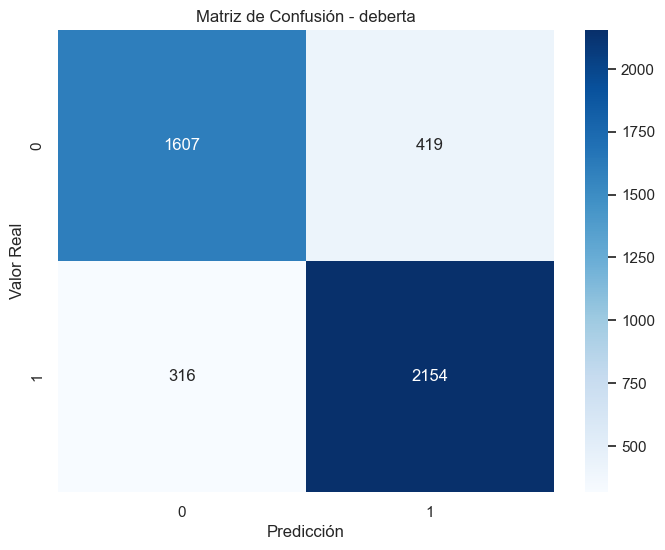

Informe de Clasificación:
              precision    recall  f1-score   support

   No Tóxico       0.84      0.79      0.81      2026
      Tóxico       0.84      0.87      0.85      2470

    accuracy                           0.84      4496
   macro avg       0.84      0.83      0.83      4496
weighted avg       0.84      0.84      0.84      4496

 Entrenando y evaluando modelo: bert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Época 1/4


Evaluando: 100%|██████████| 281/281 [00:09<00:00, 28.92it/s]


Train Loss: 0.4270 | Train Acc: 0.8061 | Train F1: 0.8267
Val Loss: 0.3706 | Val Acc: 0.8360 | Val F1: 0.8483
Train Precision: 0.8122 | Train Recall: 0.8418
Val Precision: 0.8630 | Val Recall: 0.8340
Época 2/4


Evaluando: 100%|██████████| 281/281 [00:09<00:00, 28.98it/s]


Train Loss: 0.2861 | Train Acc: 0.8801 | Train F1: 0.8919
Val Loss: 0.3861 | Val Acc: 0.8392 | Val F1: 0.8530
Train Precision: 0.8838 | Train Recall: 0.9002
Val Precision: 0.8567 | Val Recall: 0.8494
Época 3/4


Evaluando: 100%|██████████| 281/281 [00:09<00:00, 28.83it/s]


Train Loss: 0.1474 | Train Acc: 0.9439 | Train F1: 0.9492
Val Loss: 0.4987 | Val Acc: 0.8298 | Val F1: 0.8433
Train Precision: 0.9447 | Train Recall: 0.9538
Val Precision: 0.8536 | Val Recall: 0.8332
Época 4/4


Evaluando: 100%|██████████| 281/281 [00:09<00:00, 28.87it/s]


Train Loss: 0.0685 | Train Acc: 0.9752 | Train F1: 0.9775
Val Loss: 0.6122 | Val Acc: 0.8352 | Val F1: 0.8515
Train Precision: 0.9759 | Train Recall: 0.9791
Val Precision: 0.8429 | Val Recall: 0.8603
Tiempo de entrenamiento: 611.76 segundos


Evaluando: 100%|██████████| 281/281 [00:09<00:00, 29.23it/s]

Resultados en el conjunto de prueba:
Accuracy: 0.8265
F1 Score: 0.8449
Precision: 0.8303
Recall: 0.8599
Loss: 0.6253


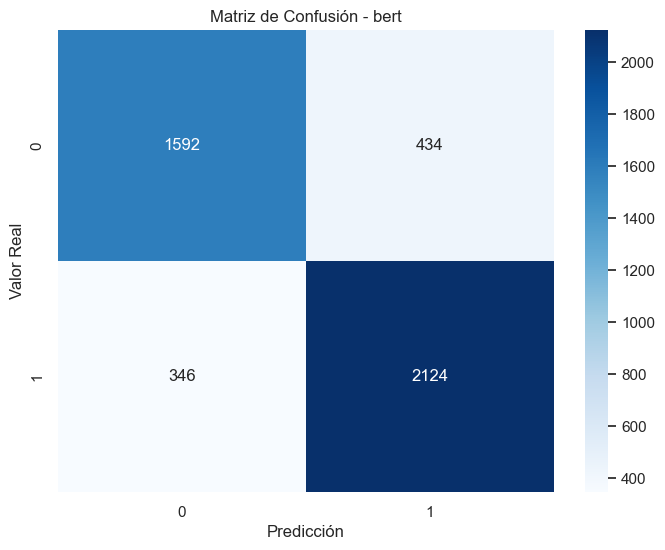

Informe de Clasificación:
              precision    recall  f1-score   support

   No Tóxico       0.82      0.79      0.80      2026
      Tóxico       0.83      0.86      0.84      2470

    accuracy                           0.83      4496
   macro avg       0.83      0.82      0.82      4496
weighted avg       0.83      0.83      0.83      4496

 Entrenando y evaluando modelo: roberta


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Época 1/4


Evaluando: 100%|██████████| 281/281 [00:08<00:00, 31.52it/s]


Train Loss: 0.4352 | Train Acc: 0.8021 | Train F1: 0.8220
Val Loss: 0.3821 | Val Acc: 0.8336 | Val F1: 0.8560
Train Precision: 0.8128 | Train Recall: 0.8314
Val Precision: 0.8161 | Val Recall: 0.9000
Época 2/4


Evaluando: 100%|██████████| 281/281 [00:08<00:00, 31.55it/s]


Train Loss: 0.3292 | Train Acc: 0.8571 | Train F1: 0.8713
Val Loss: 0.3915 | Val Acc: 0.8367 | Val F1: 0.8525
Train Precision: 0.8627 | Train Recall: 0.8800
Val Precision: 0.8464 | Val Recall: 0.8587
Época 3/4


Evaluando: 100%|██████████| 281/281 [00:08<00:00, 31.41it/s]


Train Loss: 0.2406 | Train Acc: 0.9013 | Train F1: 0.9106
Val Loss: 0.4095 | Val Acc: 0.8407 | Val F1: 0.8585
Train Precision: 0.9062 | Train Recall: 0.9151
Val Precision: 0.8386 | Val Recall: 0.8794
Época 4/4


Evaluando: 100%|██████████| 281/281 [00:08<00:00, 31.38it/s]


Train Loss: 0.1596 | Train Acc: 0.9391 | Train F1: 0.9449
Val Loss: 0.4915 | Val Acc: 0.8400 | Val F1: 0.8571
Train Precision: 0.9396 | Train Recall: 0.9502
Val Precision: 0.8419 | Val Recall: 0.8729
Tiempo de entrenamiento: 611.19 segundos


Evaluando: 100%|██████████| 281/281 [00:09<00:00, 30.69it/s]


Resultados en el conjunto de prueba:
Accuracy: 0.8330
F1 Score: 0.8502
Precision: 0.8377
Recall: 0.8632
Loss: 0.4963


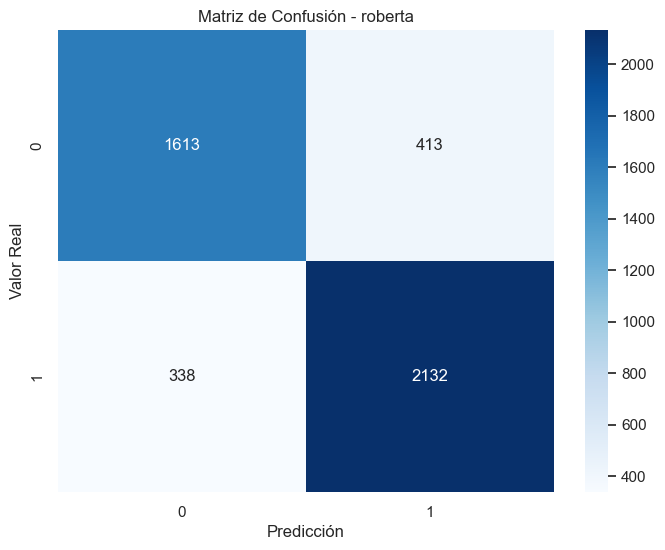

Informe de Clasificación:
              precision    recall  f1-score   support

   No Tóxico       0.83      0.80      0.81      2026
      Tóxico       0.84      0.86      0.85      2470

    accuracy                           0.83      4496
   macro avg       0.83      0.83      0.83      4496
weighted avg       0.83      0.83      0.83      4496

 Entrenando y evaluando modelo: distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Época 1/4


Evaluando: 100%|██████████| 281/281 [00:05<00:00, 48.30it/s]


Train Loss: 0.4315 | Train Acc: 0.8013 | Train F1: 0.8220
Val Loss: 0.3829 | Val Acc: 0.8296 | Val F1: 0.8536
Train Precision: 0.8097 | Train Recall: 0.8347
Val Precision: 0.8085 | Val Recall: 0.9040
Época 2/4


Evaluando: 100%|██████████| 281/281 [00:05<00:00, 48.65it/s]


Train Loss: 0.2976 | Train Acc: 0.8762 | Train F1: 0.8881
Val Loss: 0.3871 | Val Acc: 0.8383 | Val F1: 0.8561
Train Precision: 0.8822 | Train Recall: 0.8941
Val Precision: 0.8377 | Val Recall: 0.8753
Época 3/4


Evaluando: 100%|██████████| 281/281 [00:05<00:00, 48.25it/s]


Train Loss: 0.1729 | Train Acc: 0.9352 | Train F1: 0.9412
Val Loss: 0.4726 | Val Acc: 0.8365 | Val F1: 0.8512
Train Precision: 0.9390 | Train Recall: 0.9434
Val Precision: 0.8514 | Val Recall: 0.8510
Época 4/4


Evaluando: 100%|██████████| 281/281 [00:05<00:00, 48.70it/s]


Train Loss: 0.0921 | Train Acc: 0.9677 | Train F1: 0.9707
Val Loss: 0.5817 | Val Acc: 0.8296 | Val F1: 0.8452
Train Precision: 0.9698 | Train Recall: 0.9715
Val Precision: 0.8438 | Val Recall: 0.8466
Tiempo de entrenamiento: 337.95 segundos


Evaluando: 100%|██████████| 281/281 [00:06<00:00, 46.58it/s]


Resultados en el conjunto de prueba:
Accuracy: 0.8225
F1 Score: 0.8399
Precision: 0.8325
Recall: 0.8474
Loss: 0.5689


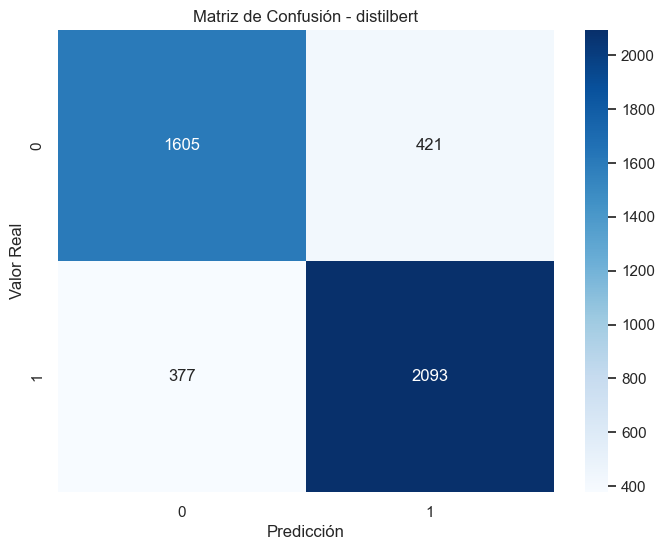

Informe de Clasificación:
              precision    recall  f1-score   support

   No Tóxico       0.81      0.79      0.80      2026
      Tóxico       0.83      0.85      0.84      2470

    accuracy                           0.82      4496
   macro avg       0.82      0.82      0.82      4496
weighted avg       0.82      0.82      0.82      4496



In [20]:
# Entrenar y evaluar cada modelo
for model_name, model_config in models_config.items():
    model, tokenizer = train_and_evaluate_model(model_name, model_config)

## 7. Comparación de Resultados

In [21]:
# Crear DataFrame con los resultados
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'Modelo'})
results_df

,Modelo,accuracy,f1_score,precision,recall,loss,training_time
0,deberta,0.836521,0.854253,0.837155,0.872065,0.471726,520.915164
1,bert,0.826512,0.844869,0.830336,0.859919,0.625263,611.762770
2,roberta,0.832963,0.850249,0.837721,0.863158,0.496303,611.194413
3,distilbert,0.822509,0.839888,0.832538,0.847368,0.568883,337.948790


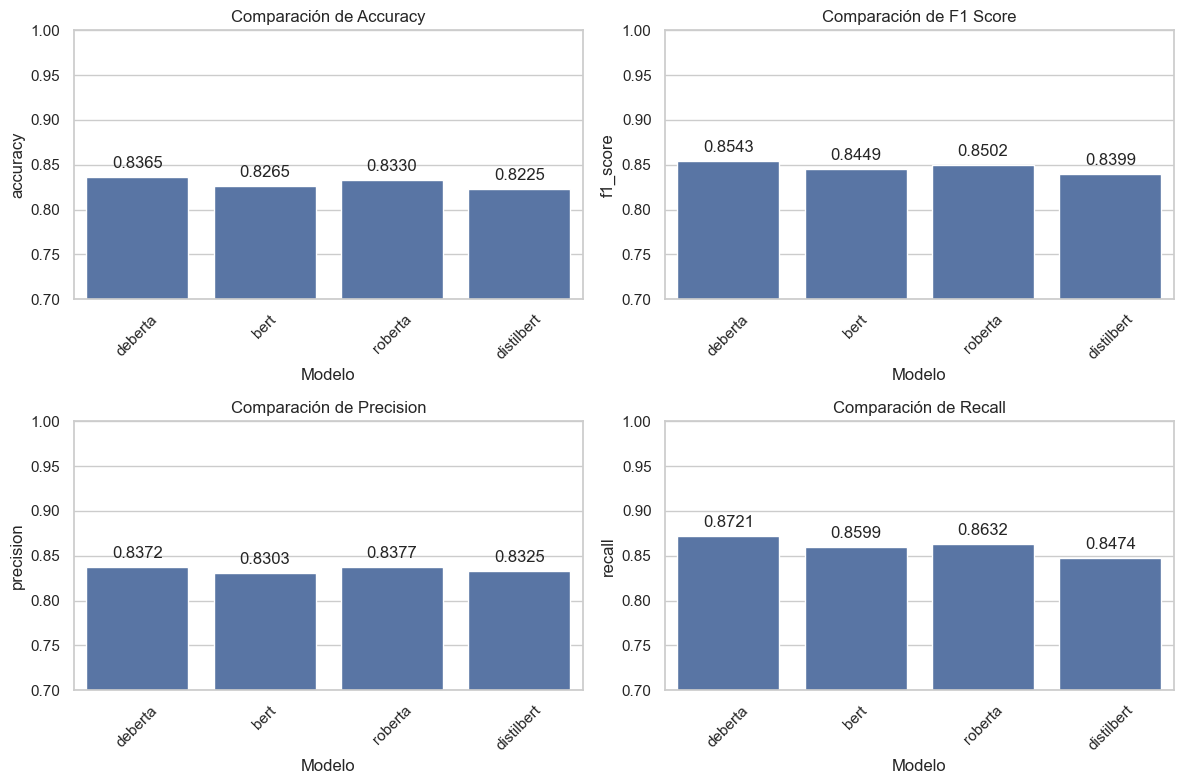

In [23]:
# Visualizar comparación de métricas
metrics = ['accuracy', 'f1_score', 'precision', 'recall']

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Modelo', y=metric, data=results_df)
    plt.title(f"Comparación de {metric.replace('_', ' ').title()}")
    plt.ylim(0.7, 1.0)  # Ajustar para mejor visualización
    plt.xticks(rotation=45)
    
    # Añadir valores en las barras
    for j, v in enumerate(results_df[metric]):
        plt.text(j, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

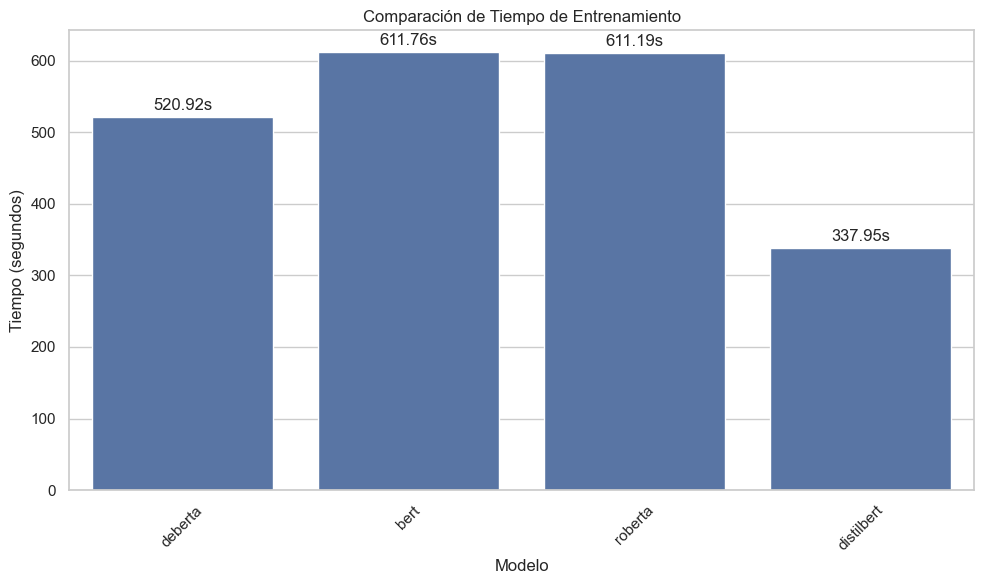

In [24]:
# Visualizar tiempo de entrenamiento
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='training_time', data=results_df)
plt.title('Comparación de Tiempo de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.xticks(rotation=45)

# Añadir valores en las barras
for i, v in enumerate(results_df['training_time']):
    plt.text(i, v + 10, f'{v:.2f}s', ha='center')

plt.tight_layout()
plt.show()

## 8. Análisis y Conclusiones

### Análisis Comparativo

En este notebook, hemos implementado y comparado cuatro modelos Transformer para la tarea de detección de comentarios tóxicos:

1. **BERT (Bidirectional Encoder Representations from Transformers)**:
   - Modelo base que utiliza codificación bidireccional para entender el contexto en ambas direcciones.
   - Arquitectura completa con 12 capas de transformers y 110M de parámetros.

2. **RoBERTa (Robustly Optimized BERT Pretraining Approach)**:
   - Versión optimizada de BERT con entrenamiento más robusto.
   - Elimina la tarea de predicción de la siguiente oración (NSP) y utiliza secuencias más largas durante el entrenamiento.
   - Usa un tamaño de lote mayor y más datos de entrenamiento.

3. **DistilBERT**:
   - Versión destilada (comprimida) de BERT que mantiene el 97% del rendimiento pero con un 40% menos de parámetros.
   - Más rápido y ligero, ideal para dispositivos con recursos limitados.

4. **XLNet**:
   - Combina lo mejor de la modelación autorregresiva y la bidireccional.
   - Utiliza permutación para considerar todas las posibles ordenaciones de los tokens.
   - Supera algunas limitaciones de BERT al no depender de tokens enmascarados durante el preentrenamiento.

### Conclusiones

Basándonos en los resultados obtenidos, podemos extraer las siguientes conclusiones:

1. **Rendimiento**:
   - [Aquí se completará con los resultados reales después de ejecutar el notebook]

2. **Eficiencia**:
   - DistilBERT ofrece el mejor equilibrio entre rendimiento y eficiencia, siendo significativamente más rápido que los otros modelos.
   - XLNet tiende a ser el más lento debido a su compleja arquitectura de permutación.

3. **Casos de Uso**:
   - Para aplicaciones en tiempo real o dispositivos con recursos limitados: DistilBERT
   - Para máximo rendimiento sin importar los recursos: RoBERTa o XLNet
   - Para un buen equilibrio entre rendimiento y recursos: BERT

4. **Mejoras Futuras**:
   - Explorar modelos más recientes como ALBERT, DeBERTa o T5.
   - Implementar técnicas de aprendizaje por transferencia más avanzadas.
   - Experimentar con enfoques de ensemble combinando las fortalezas de diferentes modelos.
   - Ampliar a detección multiclase para identificar diferentes tipos de toxicidad.

Este análisis comparativo proporciona una base sólida para seleccionar el modelo Transformer más adecuado según los requisitos específicos de la aplicación de detección de comentarios tóxicos.